In [1]:
import pandas as pd 
import numpy as np
from sqlalchemy import create_engine, text
from sqlalchemy import URL
from sqlalchemy import create_engine

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
def create_table(username, password,db_name):
    url_object = URL.create(
        "mysql+mysqlconnector",
        username=username,
        password=password,
        host="localhost",
        database=db_name
    )
    return create_engine(url_object)

In [3]:
engine = create_table('root', 'Farideh@2376', 'SuperStore')

In [4]:
query = """
SELECT s.date as `shiping date` ,o.Date as `Order Date`,Sales,  discount,Quantity, `Shipping Cost`, p.Category, p.`Sub-Category`,Segment, COALESCE(returned, 0) AS returned,Market, `Ship Mode`
FROM order_detail
JOIN product p ON order_detail.`Product ID` = p.`Product ID`
JOIN shipping s ON order_detail.`Order ID` = s.`Order ID`
JOIN `order` o ON o.`Order ID` = order_detail.`Order ID`
JOIN customer c ON o.`Customer ID` = c.`Customer ID`
LEFT JOIN returned r ON order_detail.`Order ID` = r.`Order ID`;
"""


df=pd.DataFrame(engine.connect().execute(text(query)))

In [5]:
df

,shiping date,Order Date,Sales,discount,Quantity,Shipping Cost,Category,Sub-Category,Segment,returned,Market,Ship Mode
0,2011-04-05,2011-03-31,673.568,0.200,2,54.960,Office Supplies,Binders,Consumer,0,US,Standard Class
1,2011-04-05,2011-03-31,52.980,0.000,2,3.170,Office Supplies,Appliances,Consumer,0,US,Standard Class
2,2011-09-20,2011-09-15,14.940,0.000,3,0.990,Office Supplies,Paper,Consumer,0,US,Standard Class
3,2011-09-20,2011-09-15,14.560,0.000,2,1.310,Furniture,Furnishings,Consumer,0,US,Standard Class
4,2012-10-07,2012-10-04,26.960,0.000,2,5.230,Office Supplies,Storage,Consumer,0,US,First Class
...,...,...,...,...,...,...,...,...,...,...,...,...
49665,2012-08-22,2012-08-17,1127.810,0.200,3,72.710,Furniture,Chairs,Consumer,0,EU,Standard Class
49666,2012-12-03,2012-11-26,87.984,0.400,2,9.110,Furniture,Furnishings,Consumer,1,LATAM,Standard Class
49667,2013-04-29,2013-04-24,872.320,0.000,2,68.222,Technology,Phones,Consumer,0,LATAM,Second Class
49668,2014-06-21,2014-06-18,590.117,0.002,3,106.680,Technology,Copiers,Consumer,0,LATAM,Second Class


In [6]:
df['Shipping Delay'] = (df['shiping date'] - df['Order Date']).dt.days
df.drop('shiping date' ,inplace=True,axis=1)
df.drop('Order Date' ,inplace=True,axis=1)

df

,Sales,discount,Quantity,Shipping Cost,Category,Sub-Category,Segment,returned,Market,Ship Mode,Shipping Delay
0,673.568,0.200,2,54.960,Office Supplies,Binders,Consumer,0,US,Standard Class,5
1,52.980,0.000,2,3.170,Office Supplies,Appliances,Consumer,0,US,Standard Class,5
2,14.940,0.000,3,0.990,Office Supplies,Paper,Consumer,0,US,Standard Class,5
3,14.560,0.000,2,1.310,Furniture,Furnishings,Consumer,0,US,Standard Class,5
4,26.960,0.000,2,5.230,Office Supplies,Storage,Consumer,0,US,First Class,3
...,...,...,...,...,...,...,...,...,...,...,...
49665,1127.810,0.200,3,72.710,Furniture,Chairs,Consumer,0,EU,Standard Class,5
49666,87.984,0.400,2,9.110,Furniture,Furnishings,Consumer,1,LATAM,Standard Class,7
49667,872.320,0.000,2,68.222,Technology,Phones,Consumer,0,LATAM,Second Class,5
49668,590.117,0.002,3,106.680,Technology,Copiers,Consumer,0,LATAM,Second Class,3


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49670 entries, 0 to 49669
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sales           49670 non-null  float64
 1   discount        49670 non-null  float64
 2   Quantity        49670 non-null  int64  
 3   Shipping Cost   49670 non-null  float64
 4   Category        49670 non-null  object 
 5   Sub-Category    49670 non-null  object 
 6   Segment         49670 non-null  object 
 7   returned        49670 non-null  int64  
 8   Market          49670 non-null  object 
 9   Ship Mode       49670 non-null  object 
 10  Shipping Delay  49670 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 4.2+ MB


In [8]:
df.describe()

,Sales,discount,Quantity,Shipping Cost,returned,Shipping Delay
count,49670.000000,49670.000000,49670.000000,49670.000000,49670.000000,49670.000000
mean,243.840355,0.143070,3.470787,26.041125,0.059996,3.972116
std,485.963091,0.212046,2.274854,56.870281,0.237482,1.727310
min,0.444000,0.000000,1.000000,0.002000,0.000000,0.000000
25%,30.384000,0.000000,2.000000,2.580000,0.000000,3.000000
50%,83.970000,0.000000,3.000000,7.660000,0.000000,4.000000
75%,247.830000,0.200000,5.000000,23.969000,0.000000,5.000000
max,22638.500000,0.850000,14.000000,933.570000,1.000000,7.000000


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MaxAbsScaler

columns_to_scale = [ 'Sales', 'Shipping Cost','Quantity']

scaler = QuantileTransformer()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df.head(5)

,Sales,discount,Quantity,Shipping Cost,Category,Sub-Category,Segment,returned,Market,Ship Mode,Shipping Delay
0,0.910552,0.2,0.295796,0.880717,Office Supplies,Binders,Consumer,0,US,Standard Class,5
1,0.393393,0.0,0.295796,0.295697,Office Supplies,Appliances,Consumer,0,US,Standard Class,5
2,0.113113,0.0,0.514515,0.096096,Office Supplies,Paper,Consumer,0,US,Standard Class,5
3,0.109668,0.0,0.295796,0.133133,Furniture,Furnishings,Consumer,0,US,Standard Class,5
4,0.226316,0.0,0.295796,0.409534,Office Supplies,Storage,Consumer,0,US,First Class,3


In [10]:
import category_encoders as ce
#encoder = ce.BaseNEncoder(cols=['Category','Sub-Category','Segment','Market','Ship Mode'], base=3)
#df_encoded = encoder.fit_transform(df)
#

import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=['Category','Sub-Category','Segment','Market','Ship Mode'])
df_encoded = encoder.fit_transform(df)
df_encoded.head(10)

,Sales,discount,Quantity,Shipping Cost,Category,Sub-Category,Segment,returned,Market,Ship Mode,Shipping Delay
0,0.910552,0.2,0.295796,0.880717,1,1,1,0,1,1,5
1,0.393393,0.0,0.295796,0.295697,1,2,1,0,1,1,5
2,0.113113,0.0,0.514515,0.096096,1,3,1,0,1,1,5
3,0.109668,0.0,0.295796,0.133133,2,4,1,0,1,1,5
4,0.226316,0.0,0.295796,0.409534,1,5,1,0,1,2,3
5,0.998015,0.2,0.514515,0.988367,1,6,1,0,1,1,5
6,0.002828,0.2,0.000000,0.005417,1,7,1,0,1,1,5
7,0.850912,0.2,0.514515,0.783145,3,8,1,0,1,1,5
8,0.327087,0.2,0.916416,0.321544,3,9,1,0,1,1,5
9,0.823849,0.0,0.514515,0.794066,1,2,1,0,1,1,5


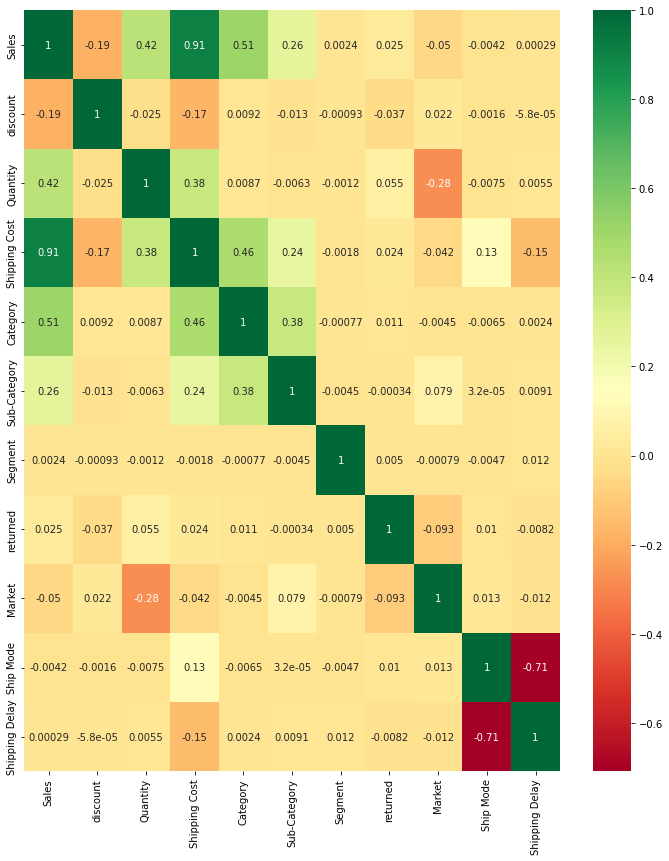

In [11]:
plt.figure(figsize=(12,14))
sns.heatmap(df_encoded.corr(),annot=True,cmap='RdYlGn');

In [12]:
X = df_encoded.drop(["Ship Mode"],axis=1)
y = df_encoded['Ship Mode']
y

0        1
1        1
2        1
3        1
4        2
        ..
49665    1
49666    1
49667    3
49668    3
49669    1
Name: Ship Mode, Length: 49670, dtype: int32

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Splitting data into train, validation and test sets with ratio of 80:10:10
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)


In [14]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,60)}

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59])})

In [16]:
knn_cv.best_params_

{'n_neighbors': 17}

In [25]:
score_knn=knn_cv.best_score_
from sklearn.metrics import recall_score, precision_score, f1_score , accuracy_score
y_pred = knn_cv.predict(X_val)

f1_score_knn = f1_score(y_val, y_pred, average='macro') 
recall_knn = recall_score(y_val, y_pred, average='macro') 
accuracy_knn = accuracy_score(y_val, y_pred)
precision_knn = precision_score(y_val, y_pred, average='macro') 

print(f'\033[94m')
print('Score          : ', score_knn.round(4))
print(f'\033[92m')
print('f1_score       : ', f1_score_knn.round(4))

print('recall_knn     : ', recall_knn.round(4))
print('accuracy_knn   : ', accuracy_knn.round(4))
print('precision_knn  : ', precision_knn.round(4))


Score          :  0.8078

f1_score       :  0.7401
recall_knn     :  0.7294
accuracy_knn   :  0.8116
precision_knn  :  0.7615
